# Main code

In [102]:
%%writefile cellular_automata.cpp


#include <mpi.h>
#include "mpi.h"
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <unistd.h>
#include <vector>
#include <algorithm>
#include <cstdlib> 


#include <string>
#include <random>
#include <fstream>


using namespace std;

void init_vector(vector<int>& cellular_automata, int n_prank, int prank)
{
    int indexes[] = {0,5,6,10,11,12,14,16,17,18,19,31,42, 52,21, n_prank + prank*n_prank}; // boundary condiion
       
    for (int i = 0; i < n_prank; i++)
    {   
        if (find(begin(indexes), end(indexes), i+prank*n_prank) != end(indexes))
        {
            cellular_automata.push_back(0);
        }
        else
        {
            cellular_automata.push_back(1);
        } 
    }
}

void add_ghost_cells(vector<int>& cellular_automata)
{
    cellular_automata.insert(cellular_automata.cbegin(),100);
    cellular_automata.push_back(100);
}

void update_cells(vector<int>& cellular_automata)
{
    vector<int> new_cell;
    for (int i = 1; i < cellular_automata.size()-1; i++)
    {
        /*
        if (i == 0 || i == cellular_automata.size()-2)
        {
            new_cell.push_back(0);
        } else
        {
            */
            int sum = cellular_automata[i-1] + cellular_automata[i] + cellular_automata[i+1];
            int sum2 = cellular_automata[i-1] + cellular_automata[i];
            if (sum == 0 || sum == 3 || sum2 == 2)
            {
                new_cell.push_back(1);
            } else
            {
                new_cell.push_back(0);
            }
       // }
    }
    
    cellular_automata.erase(cellular_automata.begin());
    cellular_automata.pop_back();
    cellular_automata.swap(new_cell);
    //new_cell.clear();

}

int are_equal(int *new_array, int *old_array, int N)
{
    int not_same = 0;
    for (int i = 0; i < N; i++)
    {
        if (new_array[i] != old_array[i])
        {
            not_same++;
        }
    
    }
    //printf("not same = %d", not_same);
    if (not_same == 0)
    {
       // printf("They are the same");
        return 11;
    } else
    {
       // printf("They are not the same");
        return 12;
    }
    
}

void print_array(int * array, int N)
{
    for (int i = 0; i < N; i++)
    {
        cout << array[i] << " ";
    }
    cout << endl;
}


int main(int argc, char ** argv) 
{
    int psize;
    int prank;
    
    MPI_Status status;

    int ierr;
    
    int work[1];
    work[0] = 1;
    
    ierr = MPI_Init(&argc, &argv);
    ierr = MPI_Comm_rank(MPI_COMM_WORLD, &prank);
    ierr = MPI_Comm_size(MPI_COMM_WORLD, &psize);
    
    int count = 0;
    int N = 100;
    int n_prank = N/psize;
    vector<int> cellular_automata;
    init_vector(cellular_automata, n_prank, prank);
    int *old_vec;
    old_vec = (int *) malloc(n_prank * psize * sizeof(int));
    
    if (prank == 0)
    {


        for (int i = 0; i < n_prank * psize; i++)
        {
            old_vec[i] =  0;
        }
    }    
    
    do {    
            count++;
            // ----- create old array ---------
            //cout << "ADD GHOST" << endl;
	    add_ghost_cells(cellular_automata);
	    
	    // -----------CHECK IF ITS OKEY--------------------------
	    /*
	    if (prank == 0)
	    {
		for (int i = 0; i < cellular_automata.size(); i++)
		{
		    cout << cellular_automata[i] << endl;
		}
	    } 
	    */
	    
	    if (prank == 0)
	    {
		MPI_Send(&cellular_automata[cellular_automata.size()-2], 
		         1, MPI_INT, prank+1, 13, MPI_COMM_WORLD);
		MPI_Recv(&cellular_automata[0],
		         1, MPI_INT, psize-1, 13, MPI_COMM_WORLD,&status);
	    } else if (prank == psize - 1)
	    {
		MPI_Send(&cellular_automata[cellular_automata.size()-2], 
		         1, MPI_INT, 0, 13, MPI_COMM_WORLD);
		MPI_Recv(&cellular_automata[0],
		         1, MPI_INT, prank-1, 13, MPI_COMM_WORLD,&status);
	    } else
	    {
		MPI_Send(&cellular_automata[cellular_automata.size()-2], 
		         1, MPI_INT, prank+1, 13, MPI_COMM_WORLD);
		MPI_Recv(&cellular_automata[0],
		         1, MPI_INT, prank-1, 13, MPI_COMM_WORLD,&status);
	    }
	    
	    if (prank == 0)
	    {
		MPI_Send(&cellular_automata[1], 
		         1, MPI_INT, psize-1, 14, MPI_COMM_WORLD);
		MPI_Recv(&cellular_automata[cellular_automata.size()-1],
		         1, MPI_INT, prank+1, 14, MPI_COMM_WORLD,&status);
	    } else if (prank == psize - 1)
	    {
		MPI_Send(&cellular_automata[1], 
		         1, MPI_INT, prank-1, 14, MPI_COMM_WORLD);
		MPI_Recv(&cellular_automata[cellular_automata.size()-1],
		         1, MPI_INT, 0, 14, MPI_COMM_WORLD,&status);
	    } else
	    {
		MPI_Send(&cellular_automata[1], 
		         1, MPI_INT, prank-1, 14, MPI_COMM_WORLD);
		MPI_Recv(&cellular_automata[cellular_automata.size()-1],
		         1, MPI_INT, prank+1, 14, MPI_COMM_WORLD,&status);
	    }

	       
	    update_cells(cellular_automata);
	    
	    
	    int *cel;
	    cel = (int *) malloc(n_prank * sizeof(int));  
	    for (int i = 0; i < n_prank; i++)
	    {
		cel[i] = cellular_automata[i];
	    }
	    
	    
	    /*
	    if (prank == 0)
	    {
		cout << " I UPDATED MY ARRAY" << endl;
		for (int i = 0; i < cellular_automata.size(); i++)
		{
		    cout << cellular_automata[i] << endl;
		}
	    }
	    
	    */
	    
	    
	    int * new_cellular_automata;
	    
	    if (prank == 0)
	    {
		new_cellular_automata = (int *) malloc(n_prank * psize * sizeof(int)); 
	    }
	    
	    MPI_Gather(cel,
		       n_prank, 
		       MPI_INT, 
		       new_cellular_automata,
		       n_prank,
		       MPI_INT,
		       0,
		       MPI_COMM_WORLD);
		       
		       
	    if (prank == 0)
	    {
          //ofstream out;
          //string s = to_string(count);
          //out.open("file"+s+".txt");
		//cout << "NEW ARRAY UPDATED" << endl;
		for (int i = 0; i < n_prank * psize; i++)
		{
		    cout << new_cellular_automata[i] << " ";
		}
		cout << endl;
		/*
		cout << "NEW ARRAY" << endl;
		print_array(new_cellular_automata, n_prank * psize);
		cout << "OLD VEC" << endl;
		print_array(old_vec, n_prank * psize);
		*/
		if (are_equal(new_cellular_automata, old_vec, n_prank * psize) == 11 || count == N)
		{
		    //printf("I AM CHANGING WORK");
		    work[0] = 0;
		} else if (are_equal(new_cellular_automata, old_vec, n_prank * psize) == 12)
		{
		    for (int i = 0; i < n_prank * psize; i++)
		    {
		        old_vec[i] = new_cellular_automata[i];
		    }
		}
	    }
	    
	    MPI_Bcast(work, 1, MPI_INT, 0,MPI_COMM_WORLD);
	    //printf("From processor %d, work = %d\n", prank, work[0]);
	    
    } while (work[0] == 1);
    
    
    /*
    
    if (prank == 0)
    {
        cout << "WE SENT ALL" << endl;
    }
    
    if (prank == 0)
    {
        cout << " I UPDATED MY ARRAY" << endl;
        for (int i = 0; i < cellular_automata.size(); i++)
        {
            cout << cellular_automata[i] << endl;
        }
    } else if (prank == 1)
    {
        cout << " I UPDATED MY ARRAY" << endl;
        for (int i = 0; i < cellular_automata.size(); i++)
        {
            cout << cellular_automata[i] << endl;
        }
    }
        
    
 
   
    free(new_cellular_automata);
    */
    ierr = MPI_Finalize();
    return 0;

}

Overwriting cellular_automata.cpp


# Code compilation

In [103]:
!mpic++ cellular_automata.cpp  -o automat


In [94]:
!mpirun --allow-run-as-root -np 4 ./automat > result.txt

# Plot the result

In [95]:
labels = []
for line in open('result.txt'):
    # array = []
    labels.append(line.strip('\n').split(" "))

res = []
for label in labels:
  result = []
  for i in range(len(label)-1):
    label[i] = int(label[i])
    result.append(label[i])
  res.append(result)

import matplotlib.pyplot as plt

plt.imsave('cellular_automata.png',res)

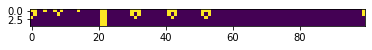

In [97]:
plt.imshow(res)